In [2]:
import os
import gc
import time
import warnings

import pandas as pd
import polars as pl
import uuid
import json
from typing import List
from datetime import datetime
import psycopg2
import re
import random
from collections import Counter
from dotenv import load_dotenv

load_dotenv()

True

In [3]:

# Login using e.g. `huggingface-cli login` to access this dataset
s1_df = pd.read_parquet("hf://datasets/simplescaling/s1K-1.1/data/train-00000-of-00001.parquet")

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Qwen-14B")
s1_df["deepseek_thinking_trajectory"].apply(lambda traj: len(tokenizer.tokenize(traj))).apply(lambda l: l <= 15700).sum()

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
Token indices sequence length is longer than the specified maximum sequence length for this model (16459 > 16384). Running this sequence through the model will result in indexing errors


np.int64(902)

In [5]:
test_trace = s1_df['deepseek_thinking_trajectory'].iloc[0]

# Regex'ing

In [6]:
start_tag = '<keep>'
end_tag = '</keep>'
s = "Hi my name is Sam. I am a student at Stanford University. I am a student at Stanford University. I am a student at Stanford University."

def return_para_w_last_sentence_wrapped(para: str, last_n_sentences: int = 2):
    # Match a period, space, and then a capital letter
    eos_regex = r'[.!?]\s[A-Z]'
    offset = 2
    
    positions = [m.start() for m in re.finditer(eos_regex, para)]
    if positions == []:
        positions = [0]
        offset = 0
    if len(positions) < last_n_sentences:
        last_n_sentences = len(positions)
    last_sentence_start = positions[-1*last_n_sentences]+offset
    last_sentence = para[last_sentence_start:]
    wrapped_sentence = f'{start_tag}{last_sentence}{end_tag}'
    wrapped_paragraph = f'{para[:last_sentence_start]}{wrapped_sentence}\n\n'
    return wrapped_paragraph


In [7]:
def insert_keep_text_at_eop(text, config: dict = {}):
    default_config = {
        'k': 3,
        'min_p_length': 300
    }
    if len(config) == 0:
        config = default_config
    else:
        config = {**default_config, **config}
    # Wrap the last sentence of every paragraph with length larger than min_p_length with <keep> tags.
    paragraphs = text.split('\n\n')
    text_wrapped = ''
    ct_para = 0
    ct_sen = 0
    for paragraph in paragraphs:
        if len(paragraph) > config['min_p_length']:
            if ct_para % config['k'] == 0:
                # Wrap the last sentence of the paragraph with <keep> tags.
                # Assume new sentences start with a capital letter
                wrapped_paragraph = return_para_w_last_sentence_wrapped(paragraph, last_n_sentences=2)
                text_wrapped += wrapped_paragraph
            else:
                text_wrapped += paragraph + '\n\n'
            ct_para += 1
        else:
            if ct_sen % config['k'] == 0:
                wrapped_paragraph = return_para_w_last_sentence_wrapped(paragraph, last_n_sentences=1)
                text_wrapped += wrapped_paragraph
            else:
                text_wrapped += paragraph + '\n\n'
            ct_sen += 1

    return text_wrapped

def insert_keep_text(text, strategy: str ='eop', config: dict = None):
    if config is None:
        config = {}
    if strategy == 'eop':
        return insert_keep_text_at_eop(text, config)
    else:
        raise ValueError(f"Invalid strategy: {strategy}")

print(insert_keep_text(test_trace, 'eop', {}))

Alright, so I need to figure out how many rational numbers between 0 and 1 have a product of the numerator and denominator (when written in lowest terms) equal to 20 factorial. <keep>Let me start by understanding the problem.</keep>

First, a rational number between 0 and 1 can be written as a fraction \(\frac{a}{b}\) where \(0 < a < b\) and \(a\) and \(b\) are coprime positive integers. The product \(a \times b\) is said to be equal to 20! which is a huge number. <keep>So I need to find all pairs \((a, b)\) such that \(a \times b = 20!\), \(0 < a < b\), and \(\gcd(a, b) = 1\). Then count how many such pairs exist.</keep>

Let me break down the problem.

Given that \(a \times b = 20!\) and \(\gcd(a, b) = 1\), it means that \(a\) and \(b\) are coprime factors of 20!. So they form a coprime pair whose product is 20!. Such pairs are related to the divisors of 20! where each pair consists of two coprime numbers.

But since the fraction is between 0 and 1, \(a < b\). So for each such coprim

In [8]:
# verify that the wrapped text without keep tags is the same as the original text
def remove_keep_text(text):
    return text.replace('</keep>', '').replace('<keep>', '')

assert remove_keep_text(insert_keep_text(test_trace, 'eop', {})).strip() == test_trace.strip()

# Prompting

In [9]:
prompt = """
You are Deepseek, an expert reasoning Large Language Model. Your task is to assist in optimizing reasoning outputs by indicating which tokens are essential for future reasoning steps.

Currently, reasoning models often wrap their thought process within <think> and </think> tags. However, this approach can lead to unnecessarily long contexts, as many tokens included might not be crucial for subsequent reasoning.

To improve this, in addition to the existing <think> ... </think> tags (which denote the overall reasoning process), you will identify and mark specific tokens to preserve using <keep> and </keep> tags. These <keep> tags explicitly highlight tokens essential for the next steps of reasoning.

Your process:

1. Read the provided question and pre-existing reasoning trace.

2. Consider carefully: "If I continue this reasoning, which tokens must be retained?"

3. Clearly indicate the exact locations for inserting <keep> and </keep> tags around tokens necessary for further generation.

Important: Be selective in choosing which tokens to wrap with <keep> tags. Strive for a balanced approach—avoid marking too few tokens, which may omit critical information, and avoid marking too many, which could reduce efficiency.

Output Format:

- Provide your selections clearly by indicating the paragraph number and the sentence number for each token or token group to retain. For example:

    - Paragraph 2, Sentence 3: <keep>essential tokens</keep>

- Ensure the text between <keep> and </keep> tags exactly matches the original text. Do not alter or paraphrase any tokens.

- Ensure the text between <keep> and </keep> tags is at least one complete sentence or phrase. You may include multiple sentences or phrases if they are closely related.

This method simulates efficient reasoning by focusing on essential tokens, optimizing context usage.
"""

def get_prompt_messsages(question, deepseek_thinking_trajectory):
    n_para = deepseek_thinking_trajectory.count('\n\n')
    user_prompt = f"""
    # Question:
    {question}

    # Deepseek Thinking Trajectory:
    {deepseek_thinking_trajectory}

    You must output at least {n_para // 5} blocks of kept text.
    """

    return [
        {"role": "system", "content": prompt},
        {"role": "user", "content": user_prompt},
    ]

In [10]:
import os
from openai import OpenAI

client_nebius = OpenAI(
      base_url="https://api.studio.nebius.com/v1/",
      api_key=os.getenv('NEBIUS_API_KEY')
  )

def generate_response_nebius(client, messages, stream=False, verbose=False):
  response = client.chat.completions.create(
      model="deepseek-ai/DeepSeek-R1",
      max_tokens=16384,
      temperature=0.9,
      top_p=0.95,
      messages=messages,
      stream=stream
  )

  if stream:
      completion = ""
      for token in response:
        if hasattr(token, 'choices'):
            completion += token.choices[0].delta.content
            if verbose:
              print(token.choices[0].delta.content, end='', flush=True)
      return completion
  else:
    return response.choices[0].message.content

# Keep Text Parsing

In [11]:
import editdistance
from matplotlib import pyplot as plt
import numpy as np
with open('ex_keep_output.txt', 'r') as f:
    ex_keep_output = f.read()
with open('test_t.txt','r') as f:
    test_trace = f.read()

def extract_keep_text(ex_keep_output) -> list[str]:
    return re.findall(r': <keep>(.*?)</keep>', ex_keep_output)

def extract_keep_text_from_response(response: str) -> list[str]:
    return re.findall(r'<keep>(.*?)</keep>', response)

keep_texts = extract_keep_text(ex_keep_output)

def check_keep_text(keep_text: list[str], test_trace: str) -> bool:
    # At most 10% of the texts can be missing
    missing_texts = 0
    for text in keep_text:
        if text not in test_trace:
            missing_texts += 1
    # print(f'{missing_texts} / {len(keep_text)} = {missing_texts / max(len(keep_text), 1)} missing texts')
    return missing_texts <= len(keep_text) * 0.1

check_keep_text(keep_texts, test_trace)

# Use word edit distance to check for close substrings
def word_edit_distance(text1: str, text2: str) -> int:
    return editdistance.eval(text1, text2)


def filter_keep_texts(keep_texts: list[str], test_trace: str) -> list[str]:
    # Filter out keep texts that aren't similar enough to the test trace
    valid_keep_texts = []
    for text in keep_texts:
        if text not in test_trace:
            # Find the closest match using word edit distance
            closest_match = min([test_trace[a:a+len(text)] for a in range(len(test_trace))], key=lambda x: word_edit_distance(text, x))

            # Only pick closest match if edit distance is more than 9 standard deviations from the mean or if there are less than 10 keep texts
            std = np.std([word_edit_distance(text, test_trace[i:i+len(text)]) for i in range(len(test_trace))])
            mean = np.mean([word_edit_distance(text, test_trace[i:i+len(text)]) for i in range(len(test_trace))])
            deviation = abs(word_edit_distance(text, closest_match) - mean)
            if deviation > 9 * std or len(keep_texts) < 10:
                valid_keep_texts.append(closest_match)
        else:
            valid_keep_texts.append(text)
    proportion_kept = len(valid_keep_texts) / max(len(keep_texts), 1)
    return valid_keep_texts, proportion_kept

valid_keep_texts, proportion_kept = filter_keep_texts(keep_texts, test_trace)
# print(f'Proportion of keep texts kept: {proportion_kept}')
assert check_keep_text(valid_keep_texts, test_trace)

In [12]:
# Insert Keep tags

def insert_keep_tags(text: str, keep_texts: list[str], debug: bool = False) -> str:
    keep_indices = set()
    for keep_text in keep_texts:
        # If the keep tag splits a word, we offset the keep tag to include the entire word
        # Find the first instance of the keep text in the text
        start_idx = text.find(keep_text)
        if start_idx != -1:
            # Find the last instance of the keep text in the text
            end_idx = start_idx + len(keep_text)
            # If the keep tag splits a word, we offset the keep tag to include the entire word
            for i in range(6):
                if start_idx > 0 and text[start_idx-1].isalnum() and text[start_idx].isalnum():
                    start_idx -= 1
                else:
                    break
            for i in range(6):
                if end_idx < len(text) and text[end_idx].isalnum() and text[end_idx+1].isalnum():
                    end_idx += 1
                else:
                    break
            # if abs(start_idx - end_idx) < 5:
            #     print("Skipping keep tag due to short length: ", text[start_idx:end_idx])
            #     continue
            keep_indices = keep_indices.union(list(range(start_idx, end_idx+1)))

            # text = text[:start_idx] + f'<keep>{text[start_idx:end_idx]}</keep>' + text[end_idx:]

    keep_indices = sorted(list(keep_indices))
    if len(keep_indices) == 0:
        return text
    keep_chunks = []
    start_chunk = keep_indices[0]
    prev = keep_indices[0]
    start_keep_offset = 6
    end_keep_offset = 7
    if len(keep_indices) > 1:
        for i in keep_indices[1:]:
            if i == prev + 1:
                prev = i
            else:
                keep_chunks.append(list(range(start_chunk, prev+1)))
                start_chunk = i
                prev = i
        keep_chunks.append(list(range(start_chunk, prev+1)))

    offset = 0
    for chunk in keep_chunks:
        text = text[:chunk[0]+offset] + f'<keep>{text[chunk[0]+offset:chunk[-1]+offset]}</keep>' + text[chunk[-1]+offset:]
        offset += end_keep_offset + start_keep_offset
    return text

text_w_keep_tags = insert_keep_tags(test_trace, valid_keep_texts)
# ensure stripped text is the same as the original text
assert remove_keep_text(text_w_keep_tags).strip() == test_trace.strip()

In [13]:
# The whole output processing

def process_keep_additions(response: str, test_trace: str) -> str:
    keep_texts = extract_keep_text(response)
    valid_keep_texts, proportion_kept = filter_keep_texts(keep_texts, test_trace)
    # print(f'Proportion of keep texts kept: {proportion_kept}')
    assert check_keep_text(valid_keep_texts, test_trace)
    text_w_keep_tags = insert_keep_tags(test_trace, valid_keep_texts)
    return text_w_keep_tags



# Synchronous call

In [14]:
import os
from tqdm import tqdm

s1_df = pd.read_parquet("hf://datasets/simplescaling/s1K-1.1/data/train-00000-of-00001.parquet")
s1_responses_dir = 'responses'
s1_questions = s1_df['question'].tolist()
s1_deepseek_thinking_trajectories = s1_df['deepseek_thinking_trajectory'].tolist()

s1_responses = []
for i, (question, deepseek_thinking_trajectory) in tqdm(enumerate(zip(s1_questions, s1_deepseek_thinking_trajectories)), total=len(s1_questions)):
    if not os.path.exists(f'{s1_responses_dir}/{i}/'):
        os.makedirs(f'{s1_responses_dir}/{i}/')
    filename = f'{s1_responses_dir}/{i}/first_run.txt'
    if os.path.exists(filename):
        with open(filename, 'r') as f:
            response = f.read()
            s1_responses.append(response)
    else:
        raise ValueError("File should exist.")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 1000/1000 [00:00<00:00, 37443.46it/s]


In [15]:
s1_id = list(range(len(s1_responses)))

In [16]:
s1_df = pd.DataFrame({
    'id': s1_id,
    'question': s1_questions,
    'reasoning': s1_deepseek_thinking_trajectories,
    'response': s1_responses
})


In [17]:
import asyncio
from tqdm.asyncio import tqdm as atqdm

# Update process_question to use the async version
async def process_question(id, question, deepseek_thinking_trajectory, semaphore, responses_dir):
    async with semaphore:
        id_index = id.split('--')[0]
        problem_id = id.split('--')[1]

        if not os.path.exists(f'{responses_dir}/{problem_id}/'):
            os.makedirs(f'{responses_dir}/{problem_id}/')
        
        filename = f'{responses_dir}/{problem_id}/{id_index}.txt'
        if os.path.exists(filename):
            with open(filename, 'r') as f:
                response = f.read()
        else:
            raise ValueError("File should exist.")
        
        # print(f'Returning response for completion {id}')
        return response


    
responses_dir = 'math_traces'
if not os.path.exists(responses_dir):
    os.makedirs(responses_dir)

prob_df = pd.read_csv("traces.csv")
aimo_reasoning = prob_df["reasoning"]
aimo_questions = prob_df["problem"]
aimo_ids = prob_df["id"]

semaphore = asyncio.Semaphore(50)
tasks = []

for (question, deepseek_thinking_trajectory, id) in zip(aimo_questions, aimo_reasoning, aimo_ids):
    task = asyncio.create_task(
        process_question(id, question, deepseek_thinking_trajectory, semaphore, responses_dir)
    )
    tasks.append(task)

aimo_responses = await atqdm.gather(*tasks)

100%|██████████| 12425/12425 [00:01<00:00, 10243.24it/s]


In [18]:
aimo_df = pd.DataFrame({
    'id': aimo_ids,
    'question': aimo_questions,
    'reasoning': aimo_reasoning,
    'response': aimo_responses
})


In [19]:
import asyncio
from tqdm.asyncio import tqdm as atqdm

openr1_df = pd.read_csv("open_r1_traces_with_tag_responses.csv")
openr1_orig_df = pd.read_csv("open_r1_traces.csv")
openr1_df.columns

Index(['question', 'deepseek_thinking_trajectory', 'response'], dtype='object')

In [20]:
openr1_df["id"] = openr1_orig_df["id"]
openr1_df.rename(columns={"deepseek_thinking_trajectory": "reasoning"}, inplace=True)

In [21]:
dpo_df = pd.concat([aimo_df, s1_df, openr1_df], ignore_index=True)

In [23]:
mask = dpo_df['response'].apply(lambda x: '<keep>' in x and '</keep>' in x and x.index('<keep>') < x.index('</keep>'))
dpo_df = dpo_df[mask]
len(dpo_df)


42549

In [24]:


# use dataset.map to do this
from datasets import Dataset

# Convert to a Hugging Face Dataset for efficient processing
dataset = Dataset.from_dict({
    'response': dpo_df['response'],
    'reasoning': dpo_df['reasoning']
})

# Define a function to process each example
def process_example(example):
    return {
        'tagged_response': process_keep_additions(
            example['response'], 
            example['reasoning']
        )
    }

# Process all examples using dataset.map
processed_dataset = dataset.map(
    process_example,
    desc="Processing tagged responses",
    num_proc=14  # Adjust based on your CPU cores
)

# Extract the processed tagged responses
tagged_responses = processed_dataset['tagged_response']

# s1_df['ds_tagged_response'] = tagged_responses


Processing tagged responses (num_proc=14):   0%|          | 0/42549 [00:00<?, ? examples/s]

In [25]:
processed_df = processed_dataset.to_pandas()

In [26]:
dpo_df = dpo_df.merge(processed_df, on='reasoning', how='inner')

In [28]:
dpo_df.to_csv('dpo_df.csv', index=False)

In [75]:
dpo_df = pd.read_csv('dpo_df.csv')

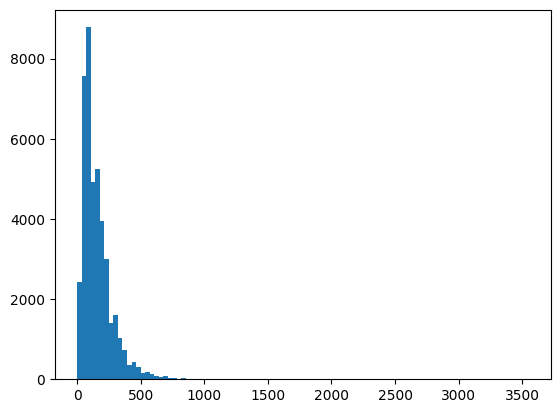

In [29]:
import math
import matplotlib.pyplot as plt
plt.hist([abs(len(t)-len(r)) for t, r in zip(dpo_df['reasoning'], dpo_df['tagged_response'])], bins=100)
plt.show()

In [30]:
equal_indices = dpo_df['reasoning'].apply(lambda x: x[:30]) == dpo_df['tagged_response'].apply(lambda x: x[:30])

In [31]:
dpo_df['diff'] = [abs(len(t)-len(r)) for t, r in zip(dpo_df['reasoning'], dpo_df['tagged_response'])]

In [32]:
# drop exact matches
mask = dpo_df.apply(lambda row: len(row['reasoning'])==len(row['tagged_response']), axis=1)

In [33]:
dpo_df = dpo_df[~mask]

In [34]:
sum(mask)

837

<Axes: >

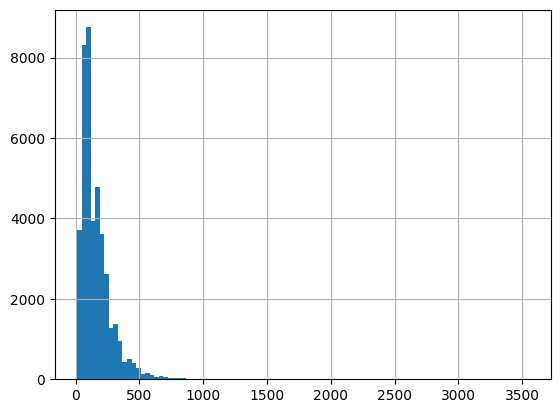

In [35]:
dpo_df['diff'].hist(bins=100)

In [36]:
dpo_df['tagged_response'].iloc[0]

"Okay, so I need to find the minimum positive integer \\( n \\geq 3 \\) such that there exist \\( n \\) points \\( A_1, A_2, \\ldots, A_n \\) with no three points collinear. <keep>Additionally, for each point \\( A_i \\), there must be another point \\( A_j \\) (where \\( j \\neq i \\)) such that the segment \\( A_jA_{j+1} \\) passes through the midpoint of segment \\( A_iA_{i+1} \\).</keep> Also, \\( A_{n+1} = A_1 \\), so the points are arranged in a cycle.\n\nFirst, I'll try to visualize the problem. We have a polygon (since the points are in a cycle) with no three points on the same line. For each edge of this polygon, the midpoint of that edge must lie on another edge of the polygon.\n\nLet me start by testing small values of \\( n \\) to see if such a configuration is possible.\n\n**Case 1: \\( n = 3 \\) (Triangle)**\n\nFor a triangle, each edge has a midpoint. We need each midpoint to lie on another edge. But in a triangle, each edge is a side, and the midpoints are the centers o

In [37]:
extracted_text = dpo_df['tagged_response'].apply(lambda x: '\n'.join(extract_keep_text_from_response(x)))

In [38]:
extracted_text.apply(lambda x: len(tokenizer.tokenize(x)) < 100).sum()

np.int64(5824)

In [39]:
dpo_df["extracted_keep_text"] = extracted_text
dpo_df["extracted_keep_text_len"] = dpo_df["extracted_keep_text"].apply(lambda x: len(tokenizer.tokenize(x)))

In [56]:
dpo_df["extracted_keep_text_len"].apply(lambda x: x < 1500 and x > 40).sum()

np.int64(40444)

<Axes: >

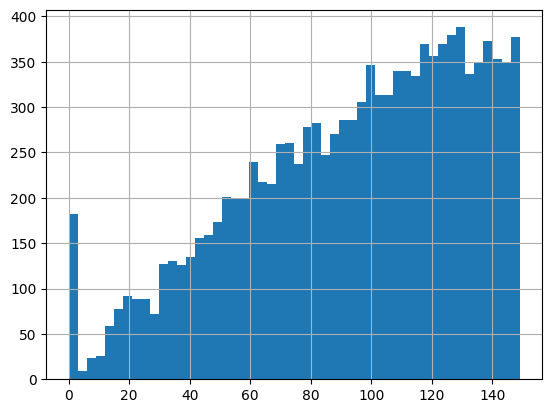

In [54]:
dpo_df[dpo_df['extracted_keep_text_len'].apply(lambda x: x < 150)]['extracted_keep_text_len'].hist(bins=50)

In [57]:
dpo_df = dpo_df[(dpo_df["extracted_keep_text_len"] < 1500) & (dpo_df["extracted_keep_text_len"] > 40)]

In [58]:
dpo_df["combined_length"] = dpo_df.apply(lambda row: len(tokenizer.tokenize(row["question"])) + len(tokenizer.tokenize(row["tagged_response"])), axis=1)

In [59]:
# format into a huggingface preference dataset
from datasets import Dataset

system_prompt = "You are a helpful AI Assistant who provides well-reasoned and accurate responses to math problems. You should think step-by-step, and the answer is an integer. Return the final answer within \\boxed{} after taking modulo 1000."

def generate_prompt(system_prompt, question):
    return [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": question}
    ]

pref_data_dict = {
    "prompt": dpo_df["question"].apply(lambda x: generate_prompt(system_prompt, x)),
    "chosen": dpo_df["tagged_response"],
    "rejected": dpo_df["reasoning"]
}

pref_dataset = Dataset.from_dict(pref_data_dict)


In [60]:

pref_dataset.push_to_hub("samitizerxu/aimo-dpo-ds", private=True)


Uploading the dataset shards:   0%|          | 0/3 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/14 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/14 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/14 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/424 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/samitizerxu/aimo-dpo-ds/commit/8e20280b63bdd8bfca56e3fc55cce34b20bf10eb', commit_message='Upload dataset', commit_description='', oid='8e20280b63bdd8bfca56e3fc55cce34b20bf10eb', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/samitizerxu/aimo-dpo-ds', endpoint='https://huggingface.co', repo_type='dataset', repo_id='samitizerxu/aimo-dpo-ds'), pr_revision=None, pr_num=None)

In [ ]:
extracted_text.apply(lambda x: len(tokenizer.tokenize(x))).hist(bins=100)

<Axes: >

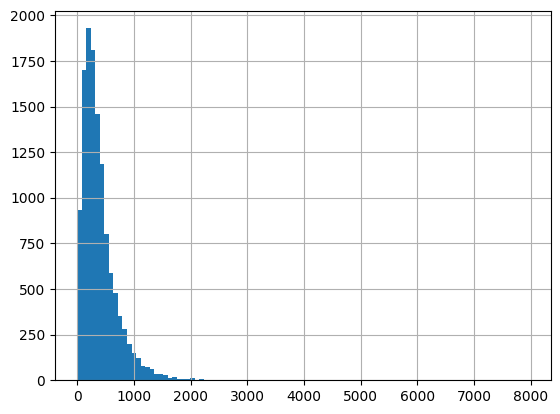

In [117]:
extracted_text.apply(lambda x: len(tokenizer.tokenize(x))).hist(bins=100)

In [93]:
j = 31
with open('ds_original_reasoning.txt', 'w') as f:
    f.write(dpo_df[dpo_df['diff'] < 200]['reasoning'].iloc[j])
with open('ds_tagged_reasoning.txt', 'w') as f:
    f.write(dpo_df[dpo_df['diff'] < 200]['tagged_response'].iloc[j])


In [33]:
from datasets import load_dataset

dataset = load_dataset("samitizerxu/aimo-dpo-ds", split="train")

In [34]:
import pandas as pd

df = pd.DataFrame(dataset)
df.columns

Index(['prompt', 'chosen', 'rejected'], dtype='object')

In [35]:
from transformers import AutoTokenizer
# Format into KTO format
from datasets import Dataset
# i.e.
kto_dataset_dict = {
    "prompt": [],
    "completion": [],
    "label": [],
}
tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Qwen-14B")

for i in range(len(df)):
    kto_dataset_dict["prompt"].append(tokenizer.apply_chat_template(df["prompt"].iloc[i], tokenize=False, add_generation_prompt=True))
    if df["chosen"].iloc[i].startswith("<think>"):
        kto_dataset_dict["completion"].append(df["chosen"].iloc[i][len("<think>"):])
    else:
        kto_dataset_dict["completion"].append(df["chosen"].iloc[i])
    kto_dataset_dict["label"].append(True)
    kto_dataset_dict["prompt"].append(tokenizer.apply_chat_template(df["prompt"].iloc[i], tokenize=False, add_generation_prompt=True))
    if df["rejected"].iloc[i].startswith("<think>"):
        kto_dataset_dict["completion"].append(df["rejected"].iloc[i][len("<think>"):])
    else:
        kto_dataset_dict["completion"].append(df["rejected"].iloc[i])
    kto_dataset_dict["label"].append(False)

# Split into train and test


In [37]:
from sklearn.model_selection import train_test_split

df = pd.DataFrame(kto_dataset_dict)
train_df, test_df = train_test_split(df, test_size=0.05, random_state=42)

# remove index column
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

kto_train_dataset = Dataset.from_pandas(train_df)
kto_test_dataset = Dataset.from_pandas(test_df)
kto_train_dataset.push_to_hub("samitizerxu/aimo-kto-ds", private=True, split="train")
kto_test_dataset.push_to_hub("samitizerxu/aimo-kto-ds", private=True, split="test")

Uploading the dataset shards:   0%|          | 0/3 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/26 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/26 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/26 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/356 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/samitizerxu/aimo-kto-ds/commit/228d884ad29565bbcbd467d49cfc27e620b4ba49', commit_message='Upload dataset', commit_description='', oid='228d884ad29565bbcbd467d49cfc27e620b4ba49', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/samitizerxu/aimo-kto-ds', endpoint='https://huggingface.co', repo_type='dataset', repo_id='samitizerxu/aimo-kto-ds'), pr_revision=None, pr_num=None)